In [146]:
#!/usr/bin/env python
import getopt, sys
from neo4j import GraphDatabase
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from pandas.io.json import json_normalize

# Global defaults, some based on our demo and some on the algo defaults.
DEFAULT_URI = "bolt://localhost:7687"
DEFAULT_USER = "neo4j"
DEFAULT_PASS = "password"
DEFAULT_REL = "Genre"
DEFAULT_LABEL = "Movie"
DEFAULT_PROP = "clusterId"
DEFAULT_P = 1.0
DEFAULT_Q = 1.0
DEFAULT_D = 16
DEFAULT_WALK = 80
DEFAULT_K=6

In [17]:
NODE2VEC_CYPHER = """
CALL gds.alpha.node2vec.stream({
  nodeProjection: $L,
  relationshipProjection: {
    EDGE: {
      type: $R,
      orientation: 'UNDIRECTED'
    }
  },
  embeddingDimension: $d,
  returnFactor: $p,
  inOutFactor: $q,
  walkLength: $l
}) YIELD nodeId, embedding
"""

UPDATE_CYPHER = """
UNWIND $updates AS updateMap
    MATCH (n) WHERE id(n) = updateMap.nodeId
    SET n += updateMap.valueMap
"""

In [18]:
def extract_embeddings(driver, label=DEFAULT_LABEL, relType=DEFAULT_REL,
                       p=DEFAULT_P, q=DEFAULT_Q, d=DEFAULT_D, l=DEFAULT_WALK):
    embeddings = []
    with driver.session() as session:
        results = session.run(NODE2VEC_CYPHER, L=label, R=relType,
                              p=float(p), q=float(q), d=int(d), l=int(l))
        for result in results:
            embeddings.append(result)
    print("...generated {} embeddings".format(len(embeddings)))
    return embeddings


def kmeans(embeddings, k=DEFAULT_K, clusterProp=DEFAULT_PROP):
    print("Performing K-Means clustering (k={}, clusterProp='{}')"
          .format(k, clusterProp))
    X = np.array([e["embedding"] for e in embeddings])
    kmeans = KMeans(n_clusters=int(k)).fit(X)
    
    #predict the labels of clusters.
    label = kmeans.predict(X)

    #Getting unique labels
    u_labels = np.unique(label)

    #plotting the results:
    for i in u_labels:
        plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i)
        
    plt.legend()
    plt.show()

    results = []
#     for idx, cluster in enumerate(kmeans.predict(X)):
#         results.append({ "nodeId": embeddings[idx]["nodeId"],
#                          "valueMap": { clusterProp: int(cluster) }})
#     print("...clustering completed.")
    return results


def update_clusters(driver, clusterResults):
    with driver.session() as session:
        result = session.write_transaction(_update_tx, UPDATE_CYPHER, updates=clusterResults)
        print("...update complete: {}".format(result.counters))


Connecting to uri: bolt://localhost:7687
...generated 9125 embeddings
Performing K-Means clustering (k=6, clusterProp='clusterId')


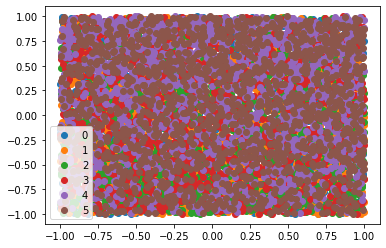

In [19]:
if __name__ == '__main__':

    uri = DEFAULT_URI
    user = DEFAULT_USER
    password = DEFAULT_PASS
    relType = DEFAULT_REL
    label = DEFAULT_LABEL
    clusterProp = DEFAULT_PROP
    p = DEFAULT_P
    q = DEFAULT_Q
    d = DEFAULT_D
    k = DEFAULT_K
    l = DEFAULT_WALK

    print("Connecting to uri: {}".format(uri))
    driver = GraphDatabase.driver(uri, auth=(user, password))
    embeddings = extract_embeddings(driver, label=label, relType=relType,
                                    p=p, q=q, d=d, l=l)
    clusters = kmeans(embeddings, k=k, clusterProp=clusterProp)
#     update_clusters(driver, clusters)
    driver.close()

In [21]:
embeddings[0]

<Record nodeId=0 embedding=[-0.2955125868320465, -0.9095728397369385, -0.5065134763717651, -0.2393861711025238, -0.1893923431634903, 0.7417477965354919, -0.46614471077919006, 0.5625435709953308, 0.3168255090713501, -0.48466160893440247, -0.07318434864282608, -0.9901276230812073, -0.16855737566947937, 0.8928540349006653, 0.7886664867401123, 0.5277740955352783]>

In [42]:
embeddings

[<Record nodeId=0 embedding=[-0.2955125868320465, -0.9095728397369385, -0.5065134763717651, -0.2393861711025238, -0.1893923431634903, 0.7417477965354919, -0.46614471077919006, 0.5625435709953308, 0.3168255090713501, -0.48466160893440247, -0.07318434864282608, -0.9901276230812073, -0.16855737566947937, 0.8928540349006653, 0.7886664867401123, 0.5277740955352783]>,
 <Record nodeId=1 embedding=[0.5667640566825867, -0.3810657262802124, 0.4957944452762604, -0.08734827488660812, -0.28907811641693115, -0.14405333995819092, 0.6013213396072388, 0.346845418214798, -0.34188219904899597, 0.3708517551422119, 0.8649969100952148, -0.713726818561554, 0.4948904514312744, 0.23732131719589233, 0.8622692227363586, -0.8011317849159241]>,
 <Record nodeId=2 embedding=[0.08712849020957947, -0.7294989228248596, -0.12369193881750107, -0.5009786486625671, 0.19798946380615234, 0.5063008666038513, -0.3269701600074768, 0.1369723528623581, 0.6213352680206299, -0.11685274541378021, -0.582740068435669, 0.25425046682357

In [34]:
user_matrix = rated.groupby('p.start.identity')['p.end.identity'].apply(list)

In [35]:
user_matrix

p.start.identity
9145    [1834, 1981, 2399, 2944, 1534, 1684, 1727, 176...
9146    [239, 226, 252, 244, 214, 203, 217, 215, 166, ...
9147    [6402, 973, 718, 1009, 985, 546, 544, 661, 636...
9148    [1131, 1130, 1119, 1107, 1098, 1096, 1079, 107...
9149    [139, 146, 52, 113, 7, 360, 408, 347, 350, 328...
                              ...                        
9210    [859, 902, 925, 957, 554, 694, 714, 748, 425, ...
9211    [0, 12, 555, 556, 546, 548, 543, 544, 541, 542...
9212    [0, 5, 20, 340, 350, 363, 422, 146, 251, 302, ...
9213    [328, 303, 341, 340, 222, 154, 285, 253, 52, 4...
9214    [669, 668, 667, 663, 680, 677, 674, 671, 709, ...
Name: p.end.identity, Length: 70, dtype: object

## Format Data for insertion 

In [ ]:
"""
acted_in = genre_normalized.loc[:, genre_normalized.columns != 'n.labels']
movies = pd.merge(movies, in_genre, how="left", on = ["n.identity"])
movies = movies.rename(columns={"p.end.identity": "genre_ID"})
in_genre.columns = in_genre.columns.str.split(".").str[-1:].str[0]
in_genre.columns = in_genre.columns.str.replace("p.end","n", 1)
"""

In [221]:
with open('movies.json','r') as f:
    genre = json.loads(f.read(), strict=False)
    
genre_normalized = pd.json_normalize(genre)

In [215]:
genre = pd.json_normalize(pd.json_normalize(genre_normalized["p.segments"])[0])[['relationship.start', 'relationship.end',
       'end.identity', 'end.properties.name']]
genre.to_csv('genre.csv', index=False)

In [210]:
genre.columns

Index(['start.identity', 'start.labels', 'start.properties.languages',
       'start.properties.year', 'start.properties.imdbId',
       'start.properties.runtime', 'start.properties.imdbRating',
       'start.properties.movieId', 'start.properties.countries',
       'start.properties.imdbVotes', 'start.properties.title',
       'start.properties.url', 'start.properties.revenue',
       'start.properties.tmdbId', 'start.properties.plot',
       'start.properties.poster', 'start.properties.released',
       'start.properties.budget', 'relationship.identity',
       'relationship.start', 'relationship.end', 'relationship.type',
       'end.identity', 'end.labels', 'end.properties.name'],
      dtype='object')

In [227]:
movies.to_csv('movies.csv', index=False)